<a href="https://colab.research.google.com/github/kimhanbut/AI_Project/blob/main/AI_CRNN_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib opencv-python python-bidi arabic-reshaper --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00


In [3]:
import os

image_dir = "/content/drive/MyDrive/Colab Notebooks/car_num/car_num_img"
json_dir = "/content/drive/MyDrive/Colab Notebooks/car_num/car_num_json"

In [98]:
import json
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import torch.nn as nn

transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class OCRDataset(Dataset):
    def __init__(self, image_dir, json_dir, transform=transform):
        self.image_dir = image_dir
        self.samples = []
        self.transform = transform

        for file_name in os.listdir(json_dir):
            if not file_name.endswith(".json"):
                continue
            with open(os.path.join(json_dir, file_name), "r", encoding="utf-8") as f:
                data = json.load(f)
                image_path = os.path.join(image_dir, data["imagePath"])
                label = data["value"]
                if os.path.exists(image_path):
                    self.samples.append((image_path, label))

        # 문자 집합 구성
        self.charset = sorted(set(char for _, label in self.samples for char in label))
        self.char2idx = {char: idx + 1 for idx, char in enumerate(self.charset)}  # 0 = blank for CTC
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        # OpenCV로 읽기 (그레이스케일)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # numpy -> PIL.Image 변환
        image = Image.fromarray(image)
        # transform이 있다면 적용 (여기서 resize도 함)
        if self.transform:
            image = self.transform(image)  # 이제 tensor로 변환됨

        label_idx = [self.char2idx[char] for char in label]
        return image, torch.tensor(label_idx, dtype=torch.long), label

    def decode(self, preds):
        # greedy decoding
        pred_text = ''
        prev_idx = -1
        for idx in preds:
            if idx != prev_idx and idx != 0:
                pred_text += self.idx2char.get(idx.item(), '')
            prev_idx = idx
        return pred_text

In [99]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()  # output: [B, 512, 1, W]
        )

        self.rnn1 = nn.LSTM(512, 512, bidirectional=True, batch_first=True)   #원래는 512, 256
        self.rnn2 = nn.LSTM(1024, 512, bidirectional=True, batch_first=True)   #원래는 512 256
        self.fc = nn.Linear(1024, num_classes)                                 #원래는 512

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        assert h == 1, f"Expected height=1, got {h}"
        x = x.squeeze(2).permute(0, 2, 1)  # [B, W, C]

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)

        x = self.fc(x)                    # [B, W, C]
        x = x.permute(1, 0, 2)            # [W, B, C] = [T, B, C]   T = timescale, B = batch size, C = class amount(0,9, 가 하..+CTC Blank 포함 )
        return x

In [100]:
from torch.nn import CTCLoss
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')


def custom_collate(batch):
    images, labels_idx, labels_str = zip(*batch)
    images = torch.stack(images)  # (B, C, H, W)

    # labels_idx는 리스트 안에 각 샘플 라벨 텐서
    targets = torch.cat(labels_idx)  # concat all target sequences

    target_lengths = torch.tensor([len(label) for label in labels_idx], dtype=torch.long)

    return images, targets, target_lengths, labels_str


dataset = OCRDataset(image_dir, json_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)


model = CRNN(num_classes=len(dataset.char2idx) + 1)  # +1 for CTC blank
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

charset = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '가', '나', '다']  # 실제 문자들
char2idx = dataset.char2idx
idx_to_char = {idx: char for char, idx in char2idx.items()}

criterion = CTCLoss(blank=0, zero_infinity=True)
optimizer = Adam(model.parameters(), lr=0.0005)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def evaluate_model(model, dataloader, criterion, idx_to_char, device):
    model.eval()
    total_loss = 0
    total_chars = 0
    correct_chars = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets, target_lengths, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            outputs = model(images)
            input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

            outputs_log_softmax = outputs.log_softmax(2)
            loss = criterion(outputs_log_softmax, targets, input_lengths, target_lengths)
            total_loss += loss.item()

            # 여기서 디코딩은 배치 사이즈가 1일 때랑 다르게 처리해야 함.
            # 일단 배치 1개씩 처리하는 예시:

            for b in range(images.size(0)):
                preds = torch.argmax(outputs[:, b, :], dim=1).cpu().numpy().tolist()

                decoded = []
                prev = -1
                for p in preds:
                    if p != prev and p != 0:
                        decoded.append(p)
                    prev = p
                pred_text = ''.join([idx_to_char[i] for i in decoded])

                start_idx = sum(target_lengths[:b])
                end_idx = start_idx + target_lengths[b].item()
                true_text = ''.join([idx_to_char[i.item()] for i in targets[start_idx:end_idx]])

                min_len = min(len(pred_text), len(true_text))
                correct_chars += sum([pred_text[i] == true_text[i] for i in range(min_len)])
                total_chars += len(true_text)

                for t_char, p_char in zip(true_text, pred_text):
                    y_true.append(t_char)
                    y_pred.append(p_char)

    acc = correct_chars / total_chars if total_chars else 0
    prec = precision_score(y_true, y_pred, average='micro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='micro', zero_division=0)

    return total_loss, acc, prec, rec

In [101]:
def pad_labels(labels):
    max_len = max(len(label) for label in labels)
    padded = torch.zeros(len(labels), max_len, dtype=torch.long)
    for i, label in enumerate(labels):
        padded[i, :len(label)] = label
    return padded



# 에폭마다 기록된 값들을 저장할 리스트
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []

for epoch in range(200):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        images, targets, target_lengths, _ = batch
        images = images.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, criterion, idx_to_char, device)

    # 결과 저장
    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")


100%|██████████| 9/9 [00:01<00:00,  8.33it/s]


[Epoch 1] Train Loss: 8.7435 | Val Loss: 9.4511 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 2] Train Loss: 32.7047 | Val Loss: 9.3084 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:00<00:00,  9.05it/s]


[Epoch 3] Train Loss: 30.9702 | Val Loss: 8.9059 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


[Epoch 4] Train Loss: 29.3005 | Val Loss: 8.5362 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


[Epoch 5] Train Loss: 25.0155 | Val Loss: 8.3411 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


[Epoch 6] Train Loss: 24.5688 | Val Loss: 8.2088 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:01<00:00,  8.78it/s]


[Epoch 7] Train Loss: 24.4217 | Val Loss: 7.9944 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 8] Train Loss: 23.6499 | Val Loss: 7.8460 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 9] Train Loss: 23.0605 | Val Loss: 7.7139 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


[Epoch 10] Train Loss: 22.7064 | Val Loss: 7.6689 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.43it/s]


[Epoch 11] Train Loss: 22.2356 | Val Loss: 7.6048 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 12] Train Loss: 22.1904 | Val Loss: 7.5262 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


[Epoch 13] Train Loss: 21.7824 | Val Loss: 7.4826 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


[Epoch 14] Train Loss: 21.4690 | Val Loss: 7.4797 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.79it/s]


[Epoch 15] Train Loss: 21.4276 | Val Loss: 7.2749 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


[Epoch 16] Train Loss: 21.1853 | Val Loss: 7.2147 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 17] Train Loss: 20.7022 | Val Loss: 7.1086 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


[Epoch 18] Train Loss: 20.6937 | Val Loss: 7.0755 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.94it/s]


[Epoch 19] Train Loss: 20.4977 | Val Loss: 6.9661 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 20] Train Loss: 20.0739 | Val Loss: 6.9672 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


[Epoch 21] Train Loss: 20.2122 | Val Loss: 6.8906 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


[Epoch 22] Train Loss: 19.8581 | Val Loss: 6.8931 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


[Epoch 23] Train Loss: 20.0289 | Val Loss: 6.8572 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


[Epoch 24] Train Loss: 19.9643 | Val Loss: 6.9381 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.47it/s]


[Epoch 25] Train Loss: 19.5177 | Val Loss: 6.7924 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.30it/s]


[Epoch 26] Train Loss: 19.8923 | Val Loss: 6.7527 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


[Epoch 27] Train Loss: 19.3443 | Val Loss: 6.7145 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


[Epoch 28] Train Loss: 19.4333 | Val Loss: 6.6990 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 29] Train Loss: 19.5066 | Val Loss: 6.7441 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.05it/s]


[Epoch 30] Train Loss: 19.0662 | Val Loss: 6.7188 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


[Epoch 31] Train Loss: 18.8955 | Val Loss: 6.6243 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.13it/s]


[Epoch 32] Train Loss: 19.1939 | Val Loss: 6.6323 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


[Epoch 33] Train Loss: 18.9614 | Val Loss: 6.6336 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


[Epoch 34] Train Loss: 18.6586 | Val Loss: 6.6389 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.39it/s]


[Epoch 35] Train Loss: 18.7000 | Val Loss: 6.6296 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


[Epoch 36] Train Loss: 18.5439 | Val Loss: 6.5583 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.24it/s]


[Epoch 37] Train Loss: 18.4797 | Val Loss: 6.4639 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


[Epoch 38] Train Loss: 18.5070 | Val Loss: 6.4723 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


[Epoch 39] Train Loss: 17.9266 | Val Loss: 6.4877 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.02it/s]


[Epoch 40] Train Loss: 18.5909 | Val Loss: 6.4024 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


[Epoch 41] Train Loss: 17.6826 | Val Loss: 6.4666 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.01it/s]


[Epoch 42] Train Loss: 18.1491 | Val Loss: 6.5347 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


[Epoch 43] Train Loss: 17.7421 | Val Loss: 6.3899 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 44] Train Loss: 17.7350 | Val Loss: 6.3149 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]


[Epoch 45] Train Loss: 17.6298 | Val Loss: 6.3445 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.01it/s]


[Epoch 46] Train Loss: 17.6165 | Val Loss: 6.3333 | Acc: 0.2857 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 9/9 [00:01<00:00,  8.18it/s]


[Epoch 47] Train Loss: 17.0547 | Val Loss: 6.4994 | Acc: 0.2857 | Precision: 0.9859 | Recall: 0.9859


100%|██████████| 9/9 [00:01<00:00,  8.79it/s]


[Epoch 48] Train Loss: 17.4381 | Val Loss: 6.2344 | Acc: 0.2857 | Precision: 0.6667 | Recall: 0.6667


100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


[Epoch 49] Train Loss: 17.4598 | Val Loss: 6.3096 | Acc: 0.2857 | Precision: 0.9859 | Recall: 0.9859


100%|██████████| 9/9 [00:00<00:00,  9.07it/s]


[Epoch 50] Train Loss: 16.9737 | Val Loss: 6.1927 | Acc: 0.3224 | Precision: 0.7054 | Recall: 0.7054


100%|██████████| 9/9 [00:01<00:00,  8.94it/s]


[Epoch 51] Train Loss: 16.6959 | Val Loss: 6.2112 | Acc: 0.3388 | Precision: 0.6860 | Recall: 0.6860


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 52] Train Loss: 16.4990 | Val Loss: 6.0545 | Acc: 0.3469 | Precision: 0.6296 | Recall: 0.6296


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 53] Train Loss: 16.5264 | Val Loss: 6.0054 | Acc: 0.3388 | Precision: 0.6103 | Recall: 0.6103


100%|██████████| 9/9 [00:01<00:00,  8.76it/s]


[Epoch 54] Train Loss: 16.1191 | Val Loss: 6.3295 | Acc: 0.3265 | Precision: 0.6452 | Recall: 0.6452


100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


[Epoch 55] Train Loss: 16.3621 | Val Loss: 5.9586 | Acc: 0.3429 | Precision: 0.6316 | Recall: 0.6316


100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


[Epoch 56] Train Loss: 15.8082 | Val Loss: 6.0024 | Acc: 0.3347 | Precision: 0.6029 | Recall: 0.6029


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


[Epoch 57] Train Loss: 15.9993 | Val Loss: 5.9020 | Acc: 0.3429 | Precision: 0.6087 | Recall: 0.6087


100%|██████████| 9/9 [00:01<00:00,  8.18it/s]


[Epoch 58] Train Loss: 16.1064 | Val Loss: 5.9074 | Acc: 0.3469 | Precision: 0.6071 | Recall: 0.6071


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


[Epoch 59] Train Loss: 16.1707 | Val Loss: 5.9147 | Acc: 0.3469 | Precision: 0.6071 | Recall: 0.6071


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 60] Train Loss: 15.9405 | Val Loss: 5.9512 | Acc: 0.3510 | Precision: 0.6143 | Recall: 0.6143


100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


[Epoch 61] Train Loss: 15.9064 | Val Loss: 5.8844 | Acc: 0.3469 | Precision: 0.6028 | Recall: 0.6028


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 62] Train Loss: 15.7002 | Val Loss: 6.1437 | Acc: 0.3469 | Precision: 0.6204 | Recall: 0.6204


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 63] Train Loss: 15.4321 | Val Loss: 6.1214 | Acc: 0.3469 | Precision: 0.6028 | Recall: 0.6028


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 64] Train Loss: 15.4929 | Val Loss: 5.9656 | Acc: 0.3510 | Precision: 0.6099 | Recall: 0.6099


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 65] Train Loss: 15.2165 | Val Loss: 5.9696 | Acc: 0.3510 | Precision: 0.6143 | Recall: 0.6143


100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


[Epoch 66] Train Loss: 15.3339 | Val Loss: 5.8276 | Acc: 0.3633 | Precision: 0.6312 | Recall: 0.6312


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


[Epoch 67] Train Loss: 14.9241 | Val Loss: 5.9199 | Acc: 0.3510 | Precision: 0.6187 | Recall: 0.6187


100%|██████████| 9/9 [00:01<00:00,  7.98it/s]


[Epoch 68] Train Loss: 15.1445 | Val Loss: 6.1825 | Acc: 0.3469 | Precision: 0.6028 | Recall: 0.6028


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


[Epoch 69] Train Loss: 14.6255 | Val Loss: 5.8808 | Acc: 0.3551 | Precision: 0.6214 | Recall: 0.6214


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


[Epoch 70] Train Loss: 14.6855 | Val Loss: 6.0182 | Acc: 0.3510 | Precision: 0.6143 | Recall: 0.6143


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


[Epoch 71] Train Loss: 14.3865 | Val Loss: 5.8725 | Acc: 0.3551 | Precision: 0.6170 | Recall: 0.6170


100%|██████████| 9/9 [00:00<00:00,  9.02it/s]


[Epoch 72] Train Loss: 14.5666 | Val Loss: 6.0196 | Acc: 0.3510 | Precision: 0.6187 | Recall: 0.6187


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


[Epoch 73] Train Loss: 14.6766 | Val Loss: 5.8743 | Acc: 0.3469 | Precision: 0.6115 | Recall: 0.6115


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 74] Train Loss: 14.7796 | Val Loss: 6.0421 | Acc: 0.3429 | Precision: 0.6000 | Recall: 0.6000


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 75] Train Loss: 14.2241 | Val Loss: 6.2591 | Acc: 0.3347 | Precision: 0.5857 | Recall: 0.5857


100%|██████████| 9/9 [00:01<00:00,  8.80it/s]


[Epoch 76] Train Loss: 14.5165 | Val Loss: 6.0221 | Acc: 0.3306 | Precision: 0.5827 | Recall: 0.5827


100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


[Epoch 77] Train Loss: 14.0024 | Val Loss: 6.0284 | Acc: 0.3388 | Precision: 0.5887 | Recall: 0.5887


100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


[Epoch 78] Train Loss: 13.9111 | Val Loss: 6.2009 | Acc: 0.3429 | Precision: 0.6087 | Recall: 0.6087


100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


[Epoch 79] Train Loss: 13.7286 | Val Loss: 5.9579 | Acc: 0.3388 | Precision: 0.5887 | Recall: 0.5887


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 80] Train Loss: 13.4859 | Val Loss: 6.1579 | Acc: 0.3388 | Precision: 0.5887 | Recall: 0.5887


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


[Epoch 81] Train Loss: 13.2636 | Val Loss: 6.1863 | Acc: 0.3469 | Precision: 0.5822 | Recall: 0.5822


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


[Epoch 82] Train Loss: 12.9745 | Val Loss: 6.0859 | Acc: 0.3388 | Precision: 0.5804 | Recall: 0.5804


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


[Epoch 83] Train Loss: 12.8762 | Val Loss: 5.9108 | Acc: 0.3388 | Precision: 0.5764 | Recall: 0.5764


100%|██████████| 9/9 [00:01<00:00,  8.71it/s]


[Epoch 84] Train Loss: 12.6493 | Val Loss: 6.0855 | Acc: 0.3469 | Precision: 0.5822 | Recall: 0.5822


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


[Epoch 85] Train Loss: 13.3115 | Val Loss: 6.1585 | Acc: 0.3347 | Precision: 0.5694 | Recall: 0.5694


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


[Epoch 86] Train Loss: 12.6908 | Val Loss: 6.1157 | Acc: 0.3429 | Precision: 0.5676 | Recall: 0.5676


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


[Epoch 87] Train Loss: 12.4620 | Val Loss: 6.0047 | Acc: 0.3429 | Precision: 0.5676 | Recall: 0.5676


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


[Epoch 88] Train Loss: 12.2801 | Val Loss: 6.2800 | Acc: 0.3429 | Precision: 0.5793 | Recall: 0.5793


100%|██████████| 9/9 [00:01<00:00,  8.10it/s]


[Epoch 89] Train Loss: 12.1727 | Val Loss: 6.3863 | Acc: 0.3510 | Precision: 0.5890 | Recall: 0.5890


100%|██████████| 9/9 [00:01<00:00,  8.96it/s]


[Epoch 90] Train Loss: 11.9991 | Val Loss: 6.2388 | Acc: 0.3551 | Precision: 0.5724 | Recall: 0.5724


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 91] Train Loss: 11.9245 | Val Loss: 6.3873 | Acc: 0.3510 | Precision: 0.5658 | Recall: 0.5658


100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


[Epoch 92] Train Loss: 11.4657 | Val Loss: 6.2400 | Acc: 0.3510 | Precision: 0.5695 | Recall: 0.5695


100%|██████████| 9/9 [00:00<00:00,  9.05it/s]


[Epoch 93] Train Loss: 11.2080 | Val Loss: 6.0109 | Acc: 0.3510 | Precision: 0.5733 | Recall: 0.5733


100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


[Epoch 94] Train Loss: 10.8972 | Val Loss: 6.3582 | Acc: 0.3429 | Precision: 0.5490 | Recall: 0.5490


100%|██████████| 9/9 [00:01<00:00,  8.78it/s]


[Epoch 95] Train Loss: 10.8473 | Val Loss: 6.3233 | Acc: 0.3673 | Precision: 0.5732 | Recall: 0.5732


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 96] Train Loss: 10.8718 | Val Loss: 6.4576 | Acc: 0.3551 | Precision: 0.5649 | Recall: 0.5649


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


[Epoch 97] Train Loss: 11.3529 | Val Loss: 6.7055 | Acc: 0.3551 | Precision: 0.5472 | Recall: 0.5472


100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


[Epoch 98] Train Loss: 10.5948 | Val Loss: 6.6805 | Acc: 0.3469 | Precision: 0.5280 | Recall: 0.5280


100%|██████████| 9/9 [00:01<00:00,  8.33it/s]


[Epoch 99] Train Loss: 10.3343 | Val Loss: 6.5095 | Acc: 0.3347 | Precision: 0.5062 | Recall: 0.5062


100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


[Epoch 100] Train Loss: 10.2720 | Val Loss: 6.5447 | Acc: 0.3633 | Precision: 0.5563 | Recall: 0.5563


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


[Epoch 101] Train Loss: 9.8673 | Val Loss: 7.1776 | Acc: 0.3510 | Precision: 0.5150 | Recall: 0.5150


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


[Epoch 102] Train Loss: 9.6920 | Val Loss: 6.8885 | Acc: 0.3510 | Precision: 0.5212 | Recall: 0.5212


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


[Epoch 103] Train Loss: 9.6402 | Val Loss: 7.2331 | Acc: 0.3551 | Precision: 0.5148 | Recall: 0.5148


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


[Epoch 104] Train Loss: 9.1975 | Val Loss: 7.0149 | Acc: 0.3551 | Precision: 0.5337 | Recall: 0.5337


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


[Epoch 105] Train Loss: 9.3212 | Val Loss: 7.1445 | Acc: 0.3347 | Precision: 0.5093 | Recall: 0.5093


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


[Epoch 106] Train Loss: 9.0636 | Val Loss: 6.9671 | Acc: 0.3429 | Precision: 0.5091 | Recall: 0.5091


100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


[Epoch 107] Train Loss: 8.8549 | Val Loss: 7.1518 | Acc: 0.3633 | Precision: 0.5361 | Recall: 0.5361


100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


[Epoch 108] Train Loss: 8.7619 | Val Loss: 7.2078 | Acc: 0.3388 | Precision: 0.5061 | Recall: 0.5061


100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


[Epoch 109] Train Loss: 8.2666 | Val Loss: 6.9535 | Acc: 0.3592 | Precision: 0.5087 | Recall: 0.5087


100%|██████████| 9/9 [00:01<00:00,  8.19it/s]


[Epoch 110] Train Loss: 8.1247 | Val Loss: 7.1938 | Acc: 0.3510 | Precision: 0.5119 | Recall: 0.5119


100%|██████████| 9/9 [00:01<00:00,  8.58it/s]


[Epoch 111] Train Loss: 8.0648 | Val Loss: 7.4039 | Acc: 0.3592 | Precision: 0.4889 | Recall: 0.4889


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


[Epoch 112] Train Loss: 8.0790 | Val Loss: 7.5040 | Acc: 0.3510 | Precision: 0.5029 | Recall: 0.5029


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


[Epoch 113] Train Loss: 8.0439 | Val Loss: 7.0579 | Acc: 0.3755 | Precision: 0.5257 | Recall: 0.5257


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 114] Train Loss: 7.7806 | Val Loss: 7.2477 | Acc: 0.3592 | Precision: 0.5087 | Recall: 0.5087


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


[Epoch 115] Train Loss: 8.0838 | Val Loss: 7.3333 | Acc: 0.3633 | Precision: 0.5235 | Recall: 0.5235


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


[Epoch 116] Train Loss: 7.7236 | Val Loss: 7.4836 | Acc: 0.3673 | Precision: 0.5233 | Recall: 0.5233


100%|██████████| 9/9 [00:01<00:00,  8.97it/s]


[Epoch 117] Train Loss: 7.1190 | Val Loss: 7.4992 | Acc: 0.3592 | Precision: 0.5269 | Recall: 0.5269


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


[Epoch 118] Train Loss: 6.7676 | Val Loss: 7.8380 | Acc: 0.3755 | Precision: 0.5111 | Recall: 0.5111


100%|██████████| 9/9 [00:01<00:00,  7.63it/s]


[Epoch 119] Train Loss: 6.7968 | Val Loss: 7.6165 | Acc: 0.3510 | Precision: 0.4804 | Recall: 0.4804


100%|██████████| 9/9 [00:01<00:00,  8.18it/s]


[Epoch 120] Train Loss: 6.6621 | Val Loss: 8.1134 | Acc: 0.3551 | Precision: 0.4860 | Recall: 0.4860


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


[Epoch 121] Train Loss: 6.0849 | Val Loss: 8.0983 | Acc: 0.3551 | Precision: 0.4860 | Recall: 0.4860


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 122] Train Loss: 5.8376 | Val Loss: 8.0252 | Acc: 0.3510 | Precision: 0.5029 | Recall: 0.5029


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


[Epoch 123] Train Loss: 5.8741 | Val Loss: 7.9978 | Acc: 0.3469 | Precision: 0.4885 | Recall: 0.4885


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 124] Train Loss: 5.8167 | Val Loss: 8.3229 | Acc: 0.3673 | Precision: 0.4945 | Recall: 0.4945


100%|██████████| 9/9 [00:00<00:00,  9.17it/s]


[Epoch 125] Train Loss: 5.8692 | Val Loss: 7.8175 | Acc: 0.3510 | Precision: 0.4914 | Recall: 0.4914


100%|██████████| 9/9 [00:00<00:00,  9.30it/s]


[Epoch 126] Train Loss: 5.6380 | Val Loss: 8.0605 | Acc: 0.3633 | Precision: 0.5000 | Recall: 0.5000


100%|██████████| 9/9 [00:00<00:00,  9.10it/s]


[Epoch 127] Train Loss: 5.4739 | Val Loss: 8.2709 | Acc: 0.3551 | Precision: 0.4807 | Recall: 0.4807


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 128] Train Loss: 5.3077 | Val Loss: 8.2411 | Acc: 0.3469 | Precision: 0.4830 | Recall: 0.4830


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


[Epoch 129] Train Loss: 4.7397 | Val Loss: 8.1807 | Acc: 0.3551 | Precision: 0.4943 | Recall: 0.4943


100%|██████████| 9/9 [00:01<00:00,  8.36it/s]


[Epoch 130] Train Loss: 4.6227 | Val Loss: 8.4447 | Acc: 0.3510 | Precision: 0.4914 | Recall: 0.4914


100%|██████████| 9/9 [00:01<00:00,  8.26it/s]


[Epoch 131] Train Loss: 4.5047 | Val Loss: 8.5013 | Acc: 0.3510 | Precision: 0.4804 | Recall: 0.4804


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


[Epoch 132] Train Loss: 4.3662 | Val Loss: 8.1781 | Acc: 0.3469 | Precision: 0.4775 | Recall: 0.4775


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 133] Train Loss: 4.2996 | Val Loss: 8.3654 | Acc: 0.3673 | Precision: 0.5028 | Recall: 0.5028


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


[Epoch 134] Train Loss: 4.2307 | Val Loss: 8.2259 | Acc: 0.3551 | Precision: 0.5029 | Recall: 0.5029


100%|██████████| 9/9 [00:00<00:00,  9.03it/s]


[Epoch 135] Train Loss: 3.9303 | Val Loss: 8.4883 | Acc: 0.3510 | Precision: 0.4751 | Recall: 0.4751


100%|██████████| 9/9 [00:00<00:00,  9.45it/s]


[Epoch 136] Train Loss: 3.9756 | Val Loss: 8.2647 | Acc: 0.3510 | Precision: 0.4725 | Recall: 0.4725


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


[Epoch 137] Train Loss: 3.8005 | Val Loss: 8.6569 | Acc: 0.3837 | Precision: 0.5109 | Recall: 0.5109


100%|██████████| 9/9 [00:01<00:00,  8.76it/s]


[Epoch 138] Train Loss: 3.4118 | Val Loss: 8.6291 | Acc: 0.3592 | Precision: 0.4862 | Recall: 0.4862


100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


[Epoch 139] Train Loss: 3.4455 | Val Loss: 8.6006 | Acc: 0.3959 | Precision: 0.5359 | Recall: 0.5359


100%|██████████| 9/9 [00:01<00:00,  8.68it/s]


[Epoch 140] Train Loss: 3.3414 | Val Loss: 8.6841 | Acc: 0.3592 | Precision: 0.4835 | Recall: 0.4835


100%|██████████| 9/9 [00:01<00:00,  8.20it/s]


[Epoch 141] Train Loss: 3.3837 | Val Loss: 8.8190 | Acc: 0.4000 | Precision: 0.5385 | Recall: 0.5385


100%|██████████| 9/9 [00:01<00:00,  8.44it/s]


[Epoch 142] Train Loss: 3.1382 | Val Loss: 8.4965 | Acc: 0.3918 | Precision: 0.5134 | Recall: 0.5134


100%|██████████| 9/9 [00:01<00:00,  8.43it/s]


[Epoch 143] Train Loss: 2.9759 | Val Loss: 8.6443 | Acc: 0.4041 | Precision: 0.5690 | Recall: 0.5690


100%|██████████| 9/9 [00:01<00:00,  8.37it/s]


[Epoch 144] Train Loss: 2.9177 | Val Loss: 8.8308 | Acc: 0.4122 | Precision: 0.5344 | Recall: 0.5344


100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


[Epoch 145] Train Loss: 2.8209 | Val Loss: 8.8969 | Acc: 0.4163 | Precision: 0.5635 | Recall: 0.5635


100%|██████████| 9/9 [00:01<00:00,  8.80it/s]


[Epoch 146] Train Loss: 2.6684 | Val Loss: 9.0503 | Acc: 0.4082 | Precision: 0.5435 | Recall: 0.5435


100%|██████████| 9/9 [00:01<00:00,  8.79it/s]


[Epoch 147] Train Loss: 2.8151 | Val Loss: 8.9291 | Acc: 0.4245 | Precision: 0.5532 | Recall: 0.5532


100%|██████████| 9/9 [00:01<00:00,  8.96it/s]


[Epoch 148] Train Loss: 2.8193 | Val Loss: 9.0157 | Acc: 0.4204 | Precision: 0.5598 | Recall: 0.5598


100%|██████████| 9/9 [00:01<00:00,  8.79it/s]


[Epoch 149] Train Loss: 2.6948 | Val Loss: 9.0967 | Acc: 0.4245 | Precision: 0.5652 | Recall: 0.5652


100%|██████████| 9/9 [00:01<00:00,  8.10it/s]


[Epoch 150] Train Loss: 2.5982 | Val Loss: 9.4013 | Acc: 0.4000 | Precision: 0.5297 | Recall: 0.5297


100%|██████████| 9/9 [00:01<00:00,  7.31it/s]


[Epoch 151] Train Loss: 2.4939 | Val Loss: 9.0727 | Acc: 0.4163 | Precision: 0.5397 | Recall: 0.5397


100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


[Epoch 152] Train Loss: 2.3029 | Val Loss: 9.2722 | Acc: 0.4204 | Precision: 0.5421 | Recall: 0.5421


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


[Epoch 153] Train Loss: 2.5163 | Val Loss: 9.3879 | Acc: 0.4327 | Precision: 0.5492 | Recall: 0.5492


100%|██████████| 9/9 [00:01<00:00,  8.96it/s]


[Epoch 154] Train Loss: 2.1163 | Val Loss: 9.1744 | Acc: 0.4286 | Precision: 0.5585 | Recall: 0.5585


100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


[Epoch 155] Train Loss: 2.1958 | Val Loss: 9.4217 | Acc: 0.4245 | Precision: 0.5652 | Recall: 0.5652


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


[Epoch 156] Train Loss: 2.0174 | Val Loss: 9.4317 | Acc: 0.4122 | Precision: 0.5549 | Recall: 0.5549


100%|██████████| 9/9 [00:00<00:00,  9.10it/s]


[Epoch 157] Train Loss: 1.9396 | Val Loss: 9.4148 | Acc: 0.4122 | Precision: 0.5372 | Recall: 0.5372


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 158] Train Loss: 1.9900 | Val Loss: 9.6794 | Acc: 0.4204 | Precision: 0.5508 | Recall: 0.5508


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


[Epoch 159] Train Loss: 1.5614 | Val Loss: 9.5129 | Acc: 0.4122 | Precision: 0.5489 | Recall: 0.5489


100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


[Epoch 160] Train Loss: 1.4972 | Val Loss: 9.3558 | Acc: 0.4286 | Precision: 0.5707 | Recall: 0.5707


100%|██████████| 9/9 [00:01<00:00,  8.44it/s]


[Epoch 161] Train Loss: 1.3770 | Val Loss: 9.5311 | Acc: 0.4408 | Precision: 0.5654 | Recall: 0.5654


100%|██████████| 9/9 [00:01<00:00,  8.07it/s]


[Epoch 162] Train Loss: 1.3989 | Val Loss: 9.6526 | Acc: 0.4163 | Precision: 0.5368 | Recall: 0.5368


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


[Epoch 163] Train Loss: 1.3741 | Val Loss: 9.6055 | Acc: 0.4122 | Precision: 0.5288 | Recall: 0.5288


100%|██████████| 9/9 [00:01<00:00,  9.00it/s]


[Epoch 164] Train Loss: 1.2899 | Val Loss: 9.5181 | Acc: 0.4367 | Precision: 0.5544 | Recall: 0.5544


100%|██████████| 9/9 [00:00<00:00,  9.01it/s]


[Epoch 165] Train Loss: 1.3148 | Val Loss: 9.6200 | Acc: 0.4163 | Precision: 0.5368 | Recall: 0.5368


100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


[Epoch 166] Train Loss: 1.3609 | Val Loss: 9.8830 | Acc: 0.4286 | Precision: 0.5615 | Recall: 0.5615


100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


[Epoch 167] Train Loss: 1.2193 | Val Loss: 9.6430 | Acc: 0.4082 | Precision: 0.5263 | Recall: 0.5263


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


[Epoch 168] Train Loss: 1.0395 | Val Loss: 9.7342 | Acc: 0.4490 | Precision: 0.5699 | Recall: 0.5699


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


[Epoch 169] Train Loss: 1.2834 | Val Loss: 9.6700 | Acc: 0.4367 | Precision: 0.5691 | Recall: 0.5691


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


[Epoch 170] Train Loss: 1.1930 | Val Loss: 10.0946 | Acc: 0.4245 | Precision: 0.5306 | Recall: 0.5306


100%|██████████| 9/9 [00:01<00:00,  8.18it/s]


[Epoch 171] Train Loss: 1.1928 | Val Loss: 10.0843 | Acc: 0.4490 | Precision: 0.5699 | Recall: 0.5699


100%|██████████| 9/9 [00:01<00:00,  8.13it/s]


[Epoch 172] Train Loss: 1.1512 | Val Loss: 10.2078 | Acc: 0.4408 | Precision: 0.5427 | Recall: 0.5427


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


[Epoch 173] Train Loss: 1.2684 | Val Loss: 9.9851 | Acc: 0.4408 | Precision: 0.5596 | Recall: 0.5596


100%|██████████| 9/9 [00:01<00:00,  8.94it/s]


[Epoch 174] Train Loss: 0.8728 | Val Loss: 9.9326 | Acc: 0.4408 | Precision: 0.5714 | Recall: 0.5714


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 175] Train Loss: 1.0123 | Val Loss: 10.1119 | Acc: 0.4571 | Precision: 0.5833 | Recall: 0.5833


100%|██████████| 9/9 [00:01<00:00,  9.00it/s]


[Epoch 176] Train Loss: 0.9206 | Val Loss: 9.9771 | Acc: 0.4449 | Precision: 0.5707 | Recall: 0.5707


100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


[Epoch 177] Train Loss: 0.8533 | Val Loss: 10.2134 | Acc: 0.4367 | Precision: 0.5691 | Recall: 0.5691


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 178] Train Loss: 0.9012 | Val Loss: 10.0750 | Acc: 0.4408 | Precision: 0.5567 | Recall: 0.5567


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


[Epoch 179] Train Loss: 0.8056 | Val Loss: 10.1967 | Acc: 0.4612 | Precision: 0.5707 | Recall: 0.5707


100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


[Epoch 180] Train Loss: 0.8224 | Val Loss: 10.2018 | Acc: 0.4449 | Precision: 0.5767 | Recall: 0.5767


100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


[Epoch 181] Train Loss: 0.5959 | Val Loss: 10.0983 | Acc: 0.4571 | Precision: 0.5744 | Recall: 0.5744


100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


[Epoch 182] Train Loss: 0.8775 | Val Loss: 10.1214 | Acc: 0.4816 | Precision: 0.5990 | Recall: 0.5990


100%|██████████| 9/9 [00:01<00:00,  8.04it/s]


[Epoch 183] Train Loss: 0.9317 | Val Loss: 10.3014 | Acc: 0.4531 | Precision: 0.5781 | Recall: 0.5781


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


[Epoch 184] Train Loss: 0.9096 | Val Loss: 10.4280 | Acc: 0.4449 | Precision: 0.5648 | Recall: 0.5648


100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


[Epoch 185] Train Loss: 1.1512 | Val Loss: 10.6359 | Acc: 0.4490 | Precision: 0.5699 | Recall: 0.5699


100%|██████████| 9/9 [00:01<00:00,  8.91it/s]


[Epoch 186] Train Loss: 1.2713 | Val Loss: 10.3968 | Acc: 0.4571 | Precision: 0.5600 | Recall: 0.5600


100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


[Epoch 187] Train Loss: 1.1644 | Val Loss: 10.5184 | Acc: 0.4571 | Precision: 0.5685 | Recall: 0.5685


100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


[Epoch 188] Train Loss: 1.2627 | Val Loss: 10.4434 | Acc: 0.4612 | Precision: 0.5678 | Recall: 0.5678


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


[Epoch 189] Train Loss: 1.6409 | Val Loss: 10.1350 | Acc: 0.4408 | Precision: 0.5455 | Recall: 0.5455


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


[Epoch 190] Train Loss: 2.0555 | Val Loss: 10.1199 | Acc: 0.4653 | Precision: 0.5561 | Recall: 0.5561


100%|██████████| 9/9 [00:01<00:00,  8.37it/s]


[Epoch 191] Train Loss: 2.5627 | Val Loss: 9.7901 | Acc: 0.4245 | Precision: 0.5389 | Recall: 0.5389


100%|██████████| 9/9 [00:01<00:00,  8.32it/s]


[Epoch 192] Train Loss: 2.6282 | Val Loss: 10.2965 | Acc: 0.4612 | Precision: 0.5650 | Recall: 0.5650


100%|██████████| 9/9 [00:01<00:00,  8.06it/s]


[Epoch 193] Train Loss: 2.4165 | Val Loss: 9.8775 | Acc: 0.4204 | Precision: 0.5337 | Recall: 0.5337


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


[Epoch 194] Train Loss: 2.3621 | Val Loss: 9.9572 | Acc: 0.4571 | Precision: 0.5833 | Recall: 0.5833


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


[Epoch 195] Train Loss: 2.1607 | Val Loss: 10.3744 | Acc: 0.4408 | Precision: 0.5538 | Recall: 0.5538


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


[Epoch 196] Train Loss: 1.5846 | Val Loss: 9.9361 | Acc: 0.4122 | Precision: 0.5288 | Recall: 0.5288


100%|██████████| 9/9 [00:00<00:00,  9.09it/s]


[Epoch 197] Train Loss: 1.4732 | Val Loss: 10.1030 | Acc: 0.4449 | Precision: 0.5737 | Recall: 0.5737


100%|██████████| 9/9 [00:01<00:00,  8.80it/s]


[Epoch 198] Train Loss: 1.0283 | Val Loss: 10.3228 | Acc: 0.4490 | Precision: 0.5670 | Recall: 0.5670


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


[Epoch 199] Train Loss: 1.2046 | Val Loss: 10.2994 | Acc: 0.4367 | Precision: 0.5377 | Recall: 0.5377


100%|██████████| 9/9 [00:01<00:00,  8.76it/s]


[Epoch 200] Train Loss: 0.7391 | Val Loss: 10.2483 | Acc: 0.4245 | Precision: 0.5389 | Recall: 0.5389


In [102]:
model.eval()
with torch.no_grad():
    for i in range(30):
        image, label_idx, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        pred = output.argmax(2)[:, 0]
        pred_text = dataset.decode(pred)
        print(f"[GT] {label} → [Pred] {pred_text}")

[GT] 01가0785 → [Pred] 01가0785
[GT] 01가0865 → [Pred] 01가0865
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01두124
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1366 → [Pred] 01두25
[GT] 01가1366 → [Pred] 01가1366
[GT] 01가1705 → [Pred] 01가1705
[GT] 01가2178 → [Pred] 01가40
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가268
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2246 → [Pred] 01가2246
[GT] 01가2319 → [Pred] 01가2319
[GT] 01가2319 → [Pred] 01가2319
[GT] 01가2512 → [Pred] 01가2512
[GT] 01가2525 → [Pred] 01가2525
[GT] 01가2567 → [Pred] 01가2567
[GT] 01가2636 → [Pred] 01가2636
[GT] 01가3005 → [Pred] 01가3005
[GT] 01가3042 → [Pred] 01가3042
[GT] 01가3315 → [Pred] 01가315
[GT] 01가3372 → [Pred] 01노72
[GT] 01가3372 → [Pred] 01가3372


In [103]:
def ctc_decode(pred_indices, blank=0):
    decoded = []
    prev = None
    for idx in pred_indices:
        if idx != blank and idx != prev:
            decoded.append(idx)
        prev = idx
    return decoded

decoded_indices = ctc_decode(pred_indices[:, 0].tolist(), blank=0)
print("Decoded indices:", decoded_indices)

Decoded indices: [1, 2, 4, 5]


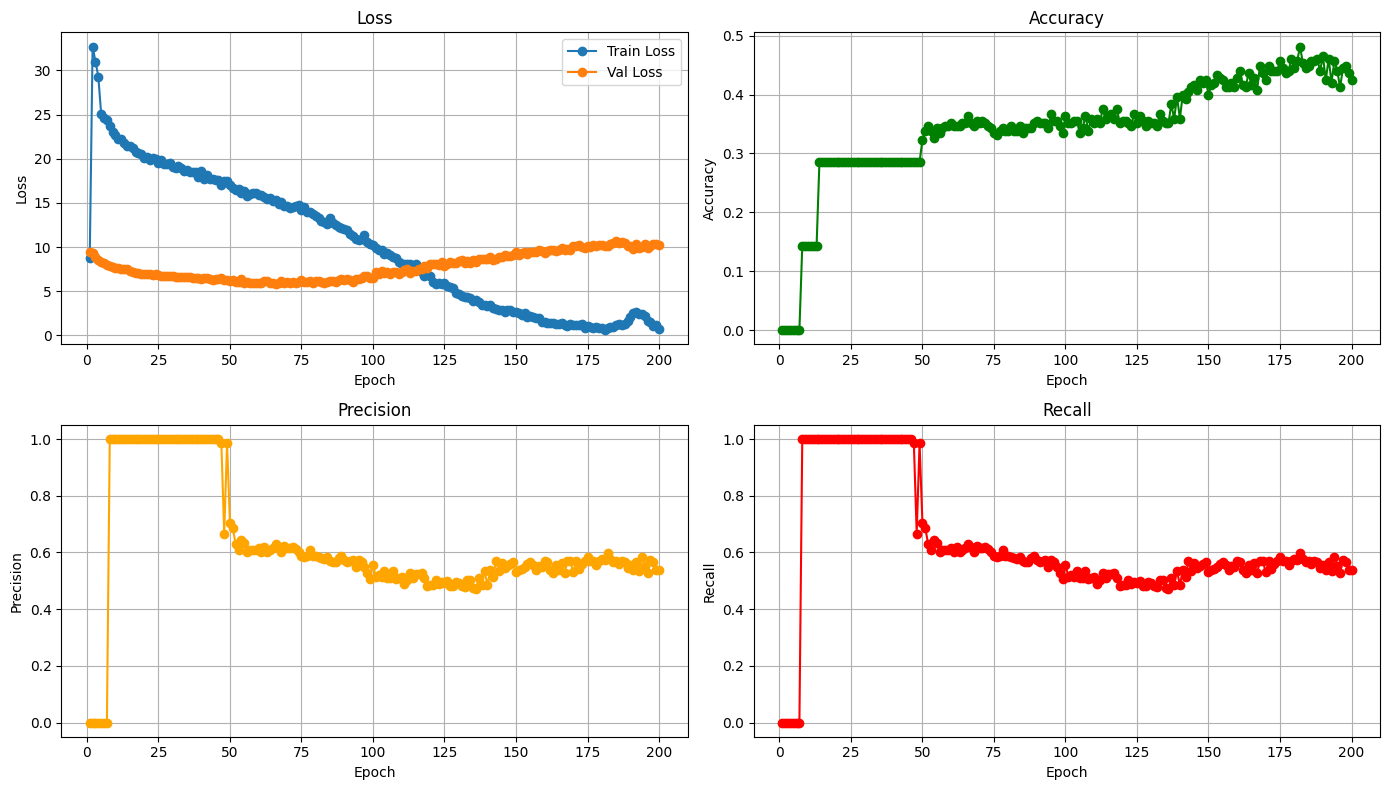

In [104]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracies, label='Accuracy', color='green', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, val_precisions, label='Precision', color='orange', marker='o')
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, val_recalls, label='Recall', color='red', marker='o')
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()